<a href="https://colab.research.google.com/github/ionut-banu/lr-stock-prices/blob/main/lr_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
from pandas_datareader import data
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
    

def fetch_data(stock, start_date, end_date):
    data_source='yahoo'
    df = data.DataReader(stock, data_source, start_date, end_date)
    df.reset_index(inplace=True,drop=False)
    return df


def add_features(prices, prev_days):
    (m, n) = prices.shape
    prices['Date'] = pd.to_datetime(prices['Date'], format='%d-%b-%y')
    prices = prices.loc[:, ['Date', 'Open', 'Close']]

    for i in range(1, prev_days + 1):
        # Add new column "Close Price at the Previous Day" and "Open Price at the Previous Day"
        prevColumn = prices.loc[:, ['Open', 'Close']].assign(index = lambda x: x.index+i)
        prevColumn = prevColumn.set_index('index')
        prices = prices.join(prevColumn, rsuffix='Prev'+str(i))
    prices = prices[prev_days:m]
    return prices


def plot_data(x, predict, y, title, suptitle):
    plt.xticks(rotation=45)
    plt.plot_date(x, y, fmt='b-', xdate=True, ydate=False, label='Real value')
    if predict is not None:
      plt.plot_date(x, predict, fmt='r-', xdate=True, ydate=False, label='Predicted value')
    plt.legend(loc='upper center')
    plt.ylabel('Close prices')
    plt.title(title, y=1.1)
    plt.suptitle(suptitle, y=0.97)
    plt.grid()
    plt.show()


def predict(X, y, date):
    # m - number of examples
    # n - number of features
    m, n = X.shape

    # test set is 30%
    # train set is 70%
    ratio = 0.25
    X_test = X.loc[:np.floor(m*ratio)]
    X_train = X.loc[np.floor(m*ratio)+1:]

    y_test = y.loc[:np.floor(m*ratio)]
    y_train = y.loc[np.floor(m*ratio)+1:]

    date_test = date.loc[:np.floor(m*ratio)]
    date_train = date.loc[np.floor(m*ratio)+1:]

    # Create linear regression object
    lr = LinearRegression()

    # Train the model using the training sets
    lr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: \n', lr.coef_)
    # The mean square error
    print("Number of variables: %d; Residual sum of squares: %.2f; Variance score: %.2f"
          % (n, np.mean((lr.predict(X_test) - y_test) ** 2), lr.score(X_test, y_test)))
    plot_data(date_test, lr.predict(X_test), y_test, 'Historical chart', stock_name)
    plot_data(date, lr.predict(X), y, 'Historical chart', stock_name)
    return lr

# Config

In [13]:
stock_name = 'AAPL'
start_date = '2020-09-15'
end_date = '2020-11-15'
prev_days = 3

# Build prices

In [14]:
prices = fetch_data(stock_name, start_date, end_date)
prices = add_features(prices, prev_days)
prices['Date2num'] = prices['Date'].apply(lambda x: mdates.date2num(x))

# Split data

In [15]:
date = prices.loc[:, ['Date']]
X = prices
y = pd.DataFrame (prices['Close'], columns = ['Close'])
del X['Date']

# Plot historical data

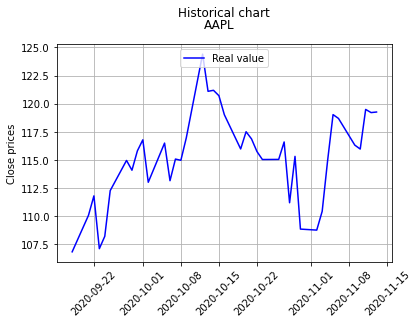

In [17]:
plot_data(date, None, y, 'Historical chart', stock_name)

# Predict

Coefficients: 
 [[ 6.70176061e-16  1.00000000e+00 -5.55111512e-17 -1.11022302e-16
   8.32667268e-16 -1.11022302e-16  4.44089210e-16 -4.44089210e-16
  -1.80411242e-16]]
Number of variables: 9; Residual sum of squares: 0.00; Variance score: 1.00


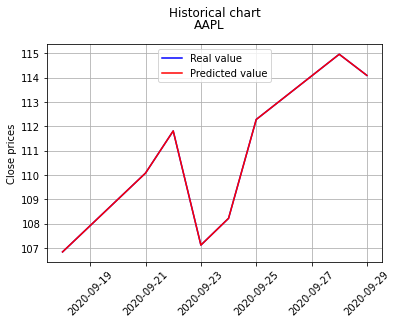

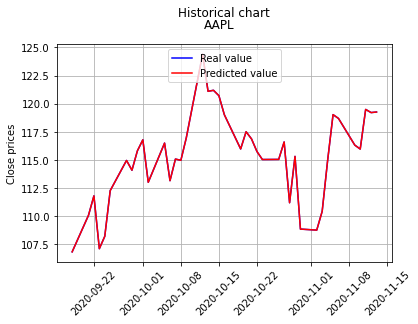

In [18]:
#features = ['Date2num', 'Open']
#X_input = X.loc[:, features]
lr = predict(X, y, date)
